# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [5]:
import pandas as pd

project = 'SPARC'
path = 'D:\\Dataframe_CSVs\\df_STA_SPARC_2021_01_22.csv'

df_sta = pd.read_csv(path)
df_sta.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude
0,S01,4,0,Left,100.0,0,0.003831
1,S01,4,0,Left,100.0,1,0.016321
2,S01,4,0,Left,100.0,2,0.006386
3,S01,4,0,Left,100.0,3,-0.023806
4,S01,4,0,Left,100.0,4,-0.050582


### For this analysis, we will only keep the right side EMG for SPARC and left side EMG for Neilsen (for now)

In [6]:
# if 'NEIL' in path: 
#     df_sta = df_sta[df_sta["Side"] == 'Left']
# else:
#     df_sta = df_sta[df_sta["Side"] == 'Right']

In [7]:
print(df_sta.Animal.unique())
print(df_sta.Day_Postop.unique())
print(df_sta.Day_Stim.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['S01' 'S02' 'S03' 'S04' 'S05' 'S06']
[ 4  6  8 10 12 14 16 18]
[ 0  2  4  6  8 10 12 14]
['Left' 'Right']
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600.]


### Add 'Time' column based on 'Sample' and a sampling frequency of 5000 Hz

In [8]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency
df_sta['Time'] = df_sta['Time']*1000
df_sta = df_sta.drop(columns=['Sample'])
df_sta.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_Amplitude,Time
0,S01,4,0,Left,100.0,0.003831,0.0
1,S01,4,0,Left,100.0,0.016321,0.2
2,S01,4,0,Left,100.0,0.006386,0.4
3,S01,4,0,Left,100.0,-0.023806,0.6
4,S01,4,0,Left,100.0,-0.050582,0.8


### Plot raw STAs

<Figure size 1440x864 with 0 Axes>

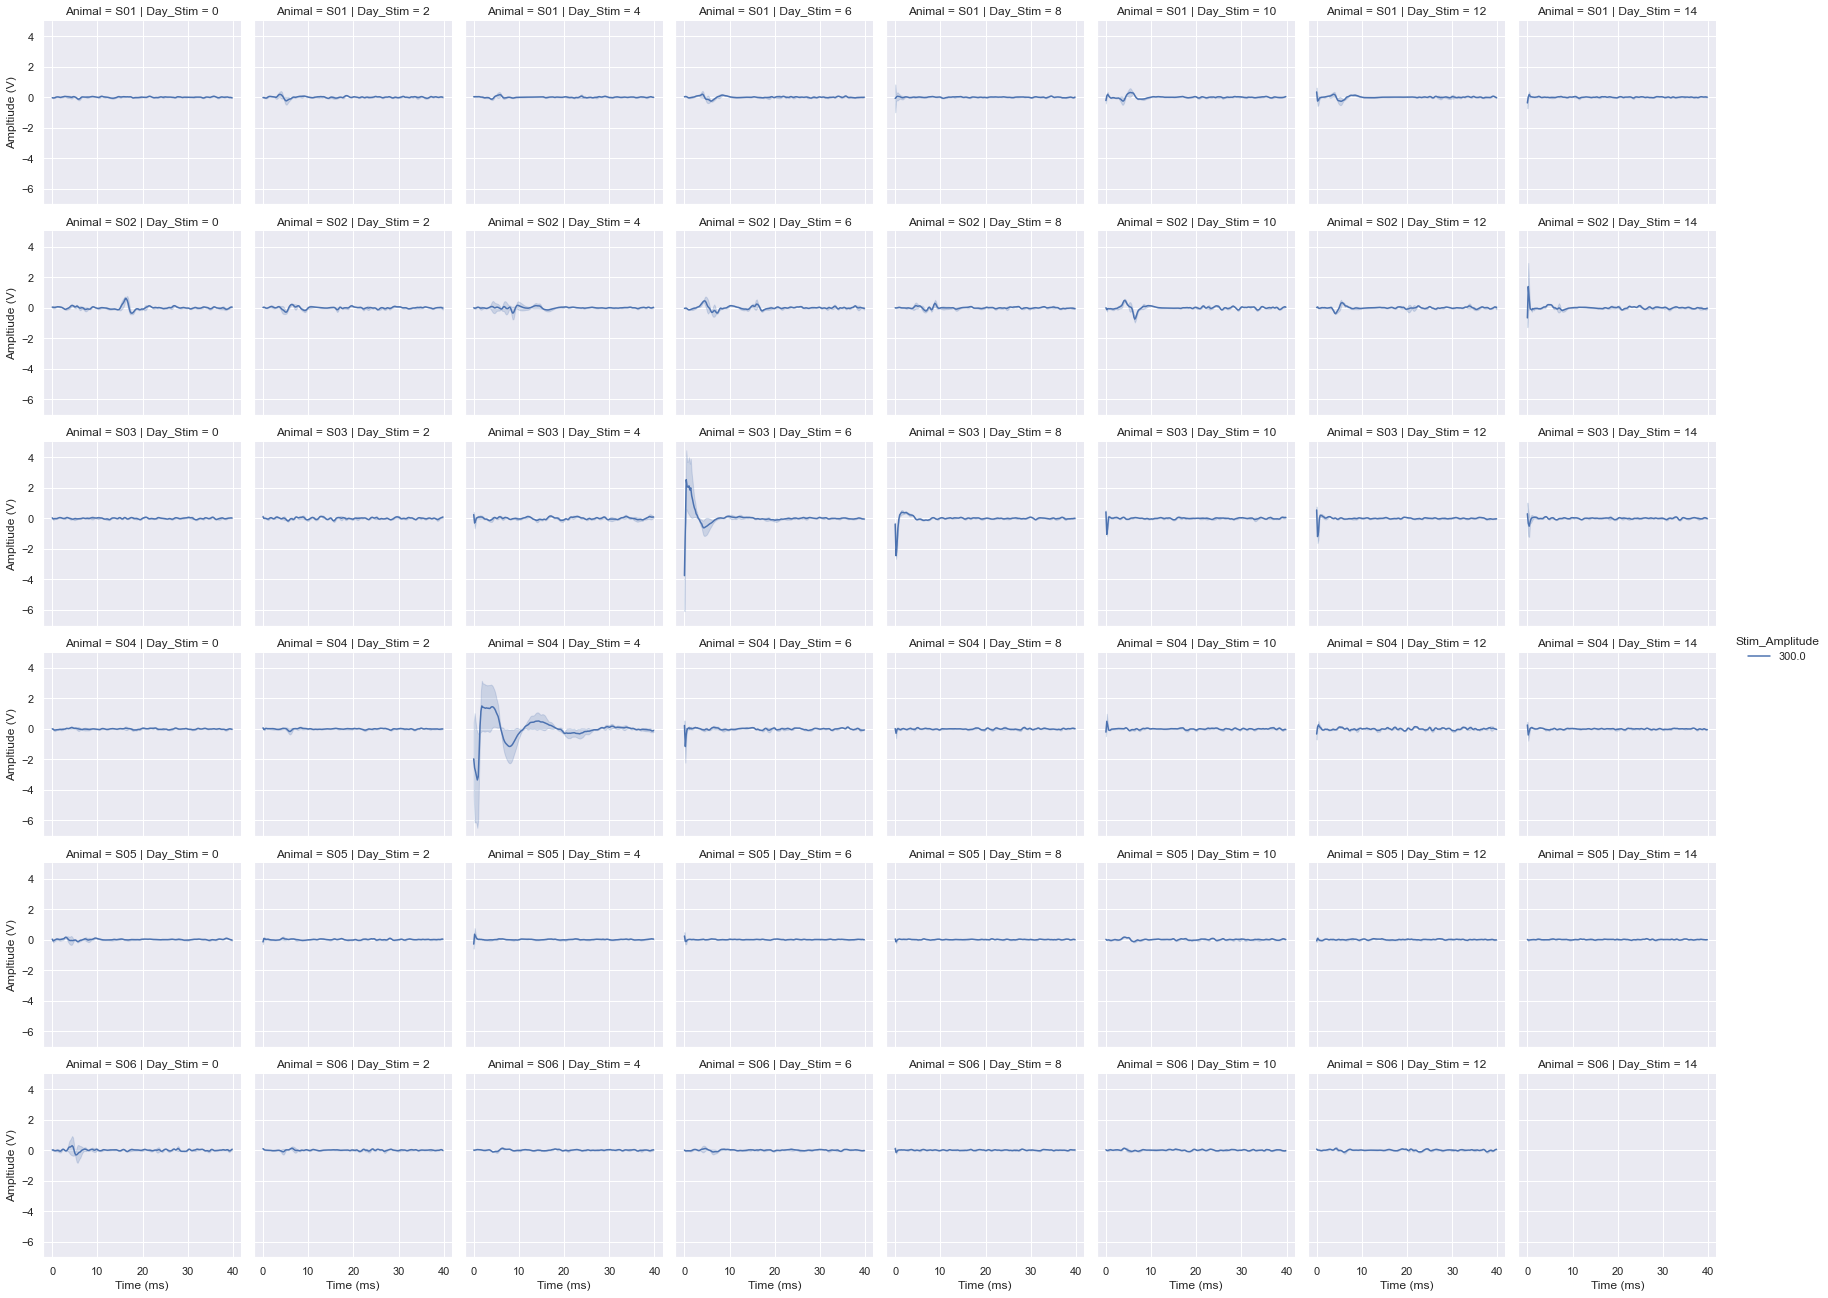

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1)
plt.figure(figsize=(20,12))
# animal_list = ['N09']
# & (df_sta['Animal'].isin(animal_list))

## you will need to subset df_sta to only plot certain stimulus amplitudes

g = sns.FacetGrid(df_sta[(df_sta['Stim_Amplitude'] == 300)], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
g.add_legend()
#plt.savefig('C:\\Users\\Ian\\Downloads\\saving-a-seaborn-plot-as-pdf-file.pdf')


### Remove stimulus artifact and re-plot STAs

In [15]:
# remove the stimulus artifact
df_sta_noart = df_sta.copy()
df_sta_noart = df_sta_noart[df_sta_noart['Time'] > 2]

<Figure size 1440x864 with 0 Axes>

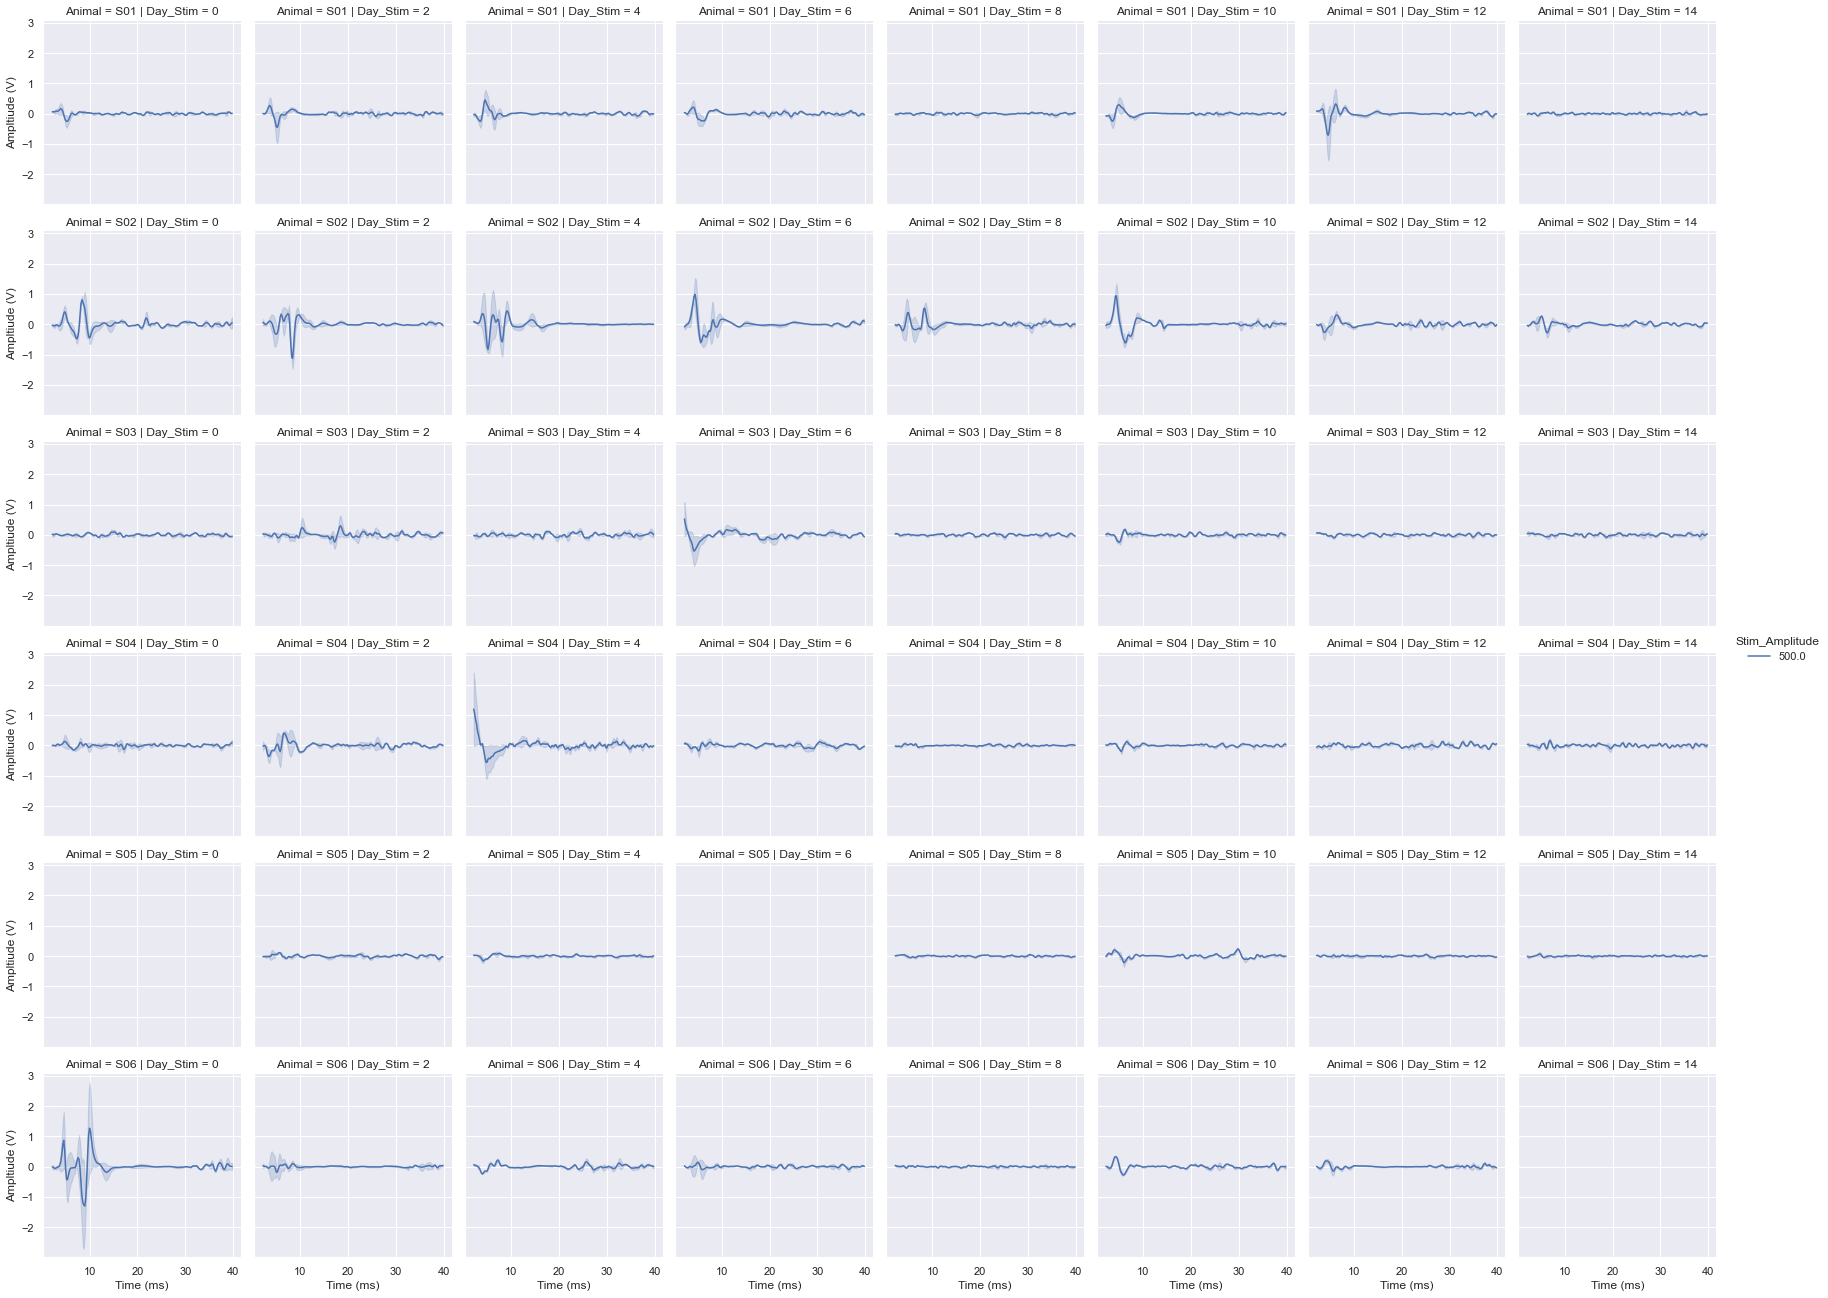

In [17]:
sns.set(font_scale=1)
plt.figure(figsize=(20,12))
# animal_list = ['N09']
# & (df_sta['Animal'].isin(animal_list))

## you will need to subset df_sta to only plot certain stimulus amplitudes

g = sns.FacetGrid(df_sta_noart[(df_sta_noart['Stim_Amplitude'] == 500)], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
g.add_legend()

### Based on the plotted STAs, remove unusable data from dataframe

In [18]:
# Delete N29 from dataframe (recordings were badly messed up)

df_sta_noart = df_sta_noart[df_sta_noart['Animal'] != 'N29']
df_sta_noart['Animal'].unique()

array(['S01', 'S02', 'S03', 'S04', 'S05', 'S06'], dtype=object)

### Find peak to peak (p2p) amplitude during STA

In [19]:
df_p2p = df_sta_noart[df_sta_noart['Time'] <= 15].copy()
df_p2p = df_p2p.groupby(['Animal', 'Day_Stim', 'Stim_Amplitude'])['STA_Amplitude'].apply(lambda x: x.max() + abs(x.min())).reset_index().rename(columns={'STA_Amplitude':'p2p_amplitude'})
df_p2p.head()

,Animal,Day_Stim,Stim_Amplitude,p2p_amplitude
0,S01,0,100.0,0.230339
1,S01,0,110.0,0.254763
2,S01,0,120.0,0.218644
3,S01,0,130.0,0.132582
4,S01,0,140.0,0.127312


### Convert all p2p amplitudes into ratios of the animal's max p2p amplitude

In [20]:
df_ratio_max = df_p2p.merge(df_p2p.groupby(['Animal'])['p2p_amplitude'].max(), on='Animal', how='left')
df_ratio_max['p2p_ratio_max'] = df_ratio_max['p2p_amplitude_x'] / df_ratio_max['p2p_amplitude_y']
df_ratio_max = df_ratio_max.drop(columns=['p2p_amplitude_x', 'p2p_amplitude_y'])
df_ratio_max.head()

,Animal,Day_Stim,Stim_Amplitude,p2p_ratio_max
0,S01,0,100.0,0.091305
1,S01,0,110.0,0.100986
2,S01,0,120.0,0.086669
3,S01,0,130.0,0.052555
4,S01,0,140.0,0.050466


### Add group information to dataframe

In [29]:
import numpy as np

### groups for NEIL project
injstim = ['N09','N10','N11','N13','N27','N28','N29','N30']
noinjstim = ['N01','N04','N05','N31','N32','N33','N34','N35'] 
injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

### groups for SPARC project
groupa = ['S01', 'S02']
groupb = ['S03', 'S04']
groupc = ['S05', 'S06']

# add animal group information to the dataframe
# make a function so you can apply to multiple dataframes
def add_group(df):
    '''This function adds Group column to dataframe based on Animal column'''
    if project == 'NEIL':
        conditions = [
            (df['Animal'].isin(injstim)),
            (df['Animal'].isin(noinjstim)),
            (df['Animal'].isin(injnostim)),
            (df['Animal'].isin(noinjnostim)) ]
        choices = ['Yes Injury, Yes Stimulation', 'No Injury, Yes Stimulation', 'Yes Injury, No Stimulation', 'No Injury, No Stimulation']
        df['Group'] = np.select(conditions, choices)
    elif project == 'SPARC':
        conditions = [
            (df['Animal'].isin(groupa)),
            (df['Animal'].isin(groupb)),
            (df['Animal'].isin(groupc)) ]
        choices = ['Group A', 'Group B', 'Group C']
        df['Group'] = np.select(conditions, choices)       

In [30]:
add_group(df_ratio_max)
df_ratio_max.head()

,Animal,Day_Stim,Stim_Amplitude,p2p_ratio_max,Group
0,S01,0,100.0,0.091305,Group A
1,S01,0,110.0,0.100986,Group A
2,S01,0,120.0,0.086669,Group A
3,S01,0,130.0,0.052555,Group A
4,S01,0,140.0,0.050466,Group A


### Check which days have data for each animal

In [31]:
df_ratio_max.groupby(['Animal'])['Day_Stim'].unique()

Animal
S01    [0, 2, 4, 6, 8, 10, 12, 14]
S02    [0, 2, 4, 6, 8, 10, 12, 14]
S03    [0, 2, 4, 6, 8, 10, 12, 14]
S04    [0, 2, 4, 6, 8, 10, 12, 14]
S05    [0, 2, 4, 6, 8, 10, 12, 14]
S06        [0, 2, 4, 6, 8, 10, 12]
Name: Day_Stim, dtype: object

### Drop day 0 out of the data set for now

In [32]:
if project == 'NEIL':
    df_ratio_max = df_ratio_max[df_ratio_max['Day_Stim']>0]
    
df_ratio_max.groupby(['Animal'])['Day_Stim'].unique()

Animal
S01    [0, 2, 4, 6, 8, 10, 12, 14]
S02    [0, 2, 4, 6, 8, 10, 12, 14]
S03    [0, 2, 4, 6, 8, 10, 12, 14]
S04    [0, 2, 4, 6, 8, 10, 12, 14]
S05    [0, 2, 4, 6, 8, 10, 12, 14]
S06        [0, 2, 4, 6, 8, 10, 12]
Name: Day_Stim, dtype: object

### Plot all p2p amplitudes to get a general idea of what the data look like

<Figure size 1440x1440 with 0 Axes>

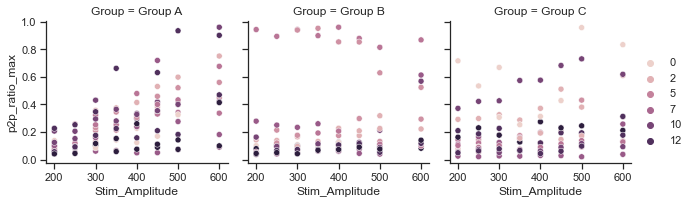

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

stim_amp_list = [200, 250, 300, 350, 400, 450, 500, 600]

plt.figure(figsize=(20,20))
sns.set_style("ticks")
g = sns.FacetGrid(df_ratio_max[df_ratio_max['Stim_Amplitude'].isin(stim_amp_list)], col="Group")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_ratio_max", 'Day_Stim').add_legend())

In [51]:
df_auc['Day_Stim'].unique()

array([ 0,  2,  4,  6,  8, 10, 12, 14], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

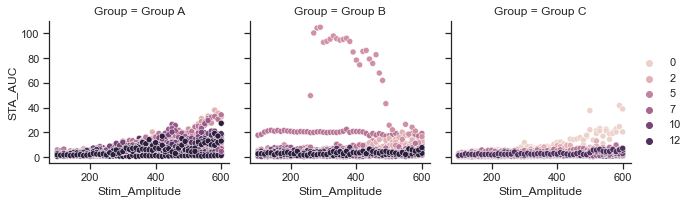

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.set_style("ticks")
g = sns.FacetGrid(df_auc, col="Group")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "STA_AUC", 'Day_Stim').add_legend())

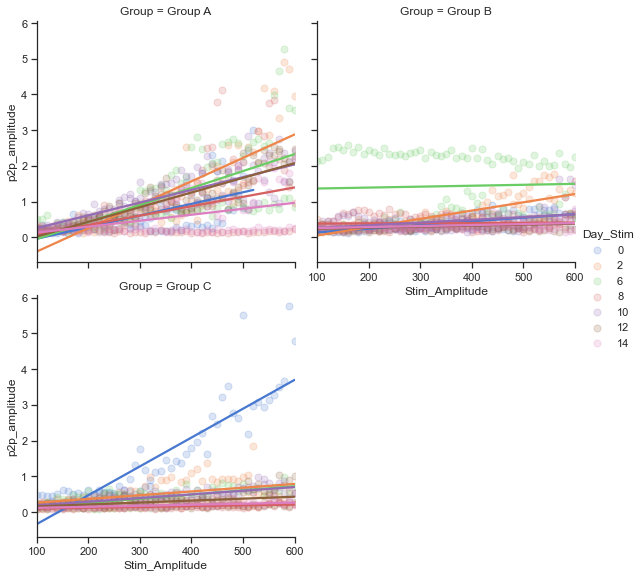

In [55]:
sns.lmplot(x="Stim_Amplitude", y="p2p_amplitude", col="Group", hue="Day_Stim", data=df_p2p[df_p2p['Day_Stim'] != 4],
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 0.2})

### Fit lines by group and day to visualize change over time (and stim amplitude) for each group

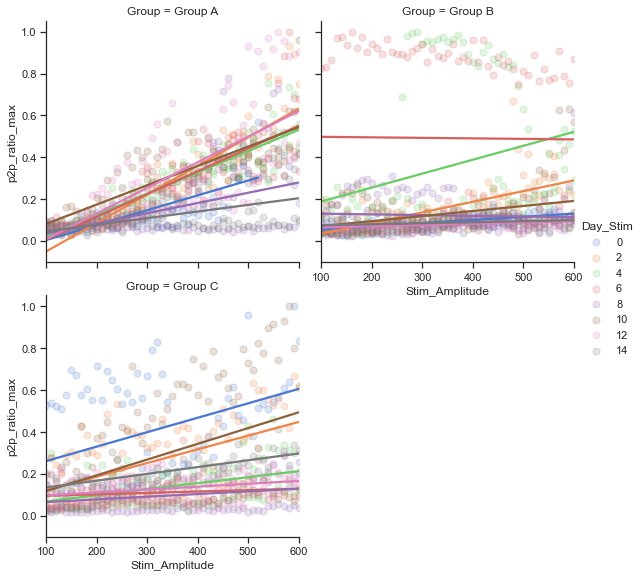

In [36]:
sns.lmplot(x="Stim_Amplitude", y="p2p_ratio_max", col="Group", hue="Day_Stim", data=df_ratio_max,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 0.2})

### Calculate statistics on the plotted lines above
##### slope, intercept, r_value, p_value, std_err

Make dataframes for each group. This will make it easier to subset in the next step.

In [18]:
# group: no injury, no stimulation
df_nn = df_ratio_max[df_ratio_max['Group'] == 'No Injury, No Stimulation']
df_nn1 = df_nn[df_nn['Day_Stim'] == 1]
df_nn2 = df_nn[df_nn['Day_Stim'] == 2]
df_nn3 = df_nn[df_nn['Day_Stim'] == 3]
df_nn4 = df_nn[df_nn['Day_Stim'] == 4]

# group: no injury, yes stimulation
df_ny = df_ratio_max[df_ratio_max['Group'] == 'No Injury, Yes Stimulation']
df_ny1 = df_ny[df_ny['Day_Stim'] == 1]
df_ny2 = df_ny[df_ny['Day_Stim'] == 2]
df_ny3 = df_ny[df_ny['Day_Stim'] == 3]
df_ny4 = df_ny[df_ny['Day_Stim'] == 4]

# group: yes injury, no stimulation
df_yn = df_ratio_max[df_ratio_max['Group'] == 'Yes Injury, No Stimulation']
df_yn1 = df_yn[df_yn['Day_Stim'] == 1]
df_yn2 = df_yn[df_yn['Day_Stim'] == 2]
df_yn3 = df_yn[df_yn['Day_Stim'] == 3]
df_yn4 = df_yn[df_yn['Day_Stim'] == 4]

# group: yes injury, yes stimulation
df_yy = df_ratio_max[df_ratio_max['Group'] == 'Yes Injury, Yes Stimulation']
df_yy1 = df_yy[df_yy['Day_Stim'] == 1]
df_yy2 = df_yy[df_yy['Day_Stim'] == 2]
df_yy3 = df_yy[df_yy['Day_Stim'] == 3]
df_yy4 = df_yy[df_yy['Day_Stim'] == 4]

In [19]:
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

df = df_yy4

X = df['Stim_Amplitude']
y = df['p2p_ratio_max']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          p2p_ratio_max   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     277.7
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           7.74e-48
Time:                        12:46:30   Log-Likelihood:                 71.387
No. Observations:                 406   AIC:                            -138.8
Df Residuals:                     404   BIC:                            -130.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0706      0.022     -3.

### Apply linear mixed effects model (random slopes) to data plotted above

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = sm.MixedLM.from_formula("p2p_ratio_max ~ Stim_Amplitude", df_ratio_max, re_formula="Stim_Amplitude", groups=df_ratio_max["Group"])

mdf = md.fit()

print(mdf.summary())

C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    p2p_ratio_max
No. Observations:    3702       Method:                REML         
No. Groups:          4          Scale:                 0.0368       
Min. group size:     168        Log-Likelihood:        838.5089     
Max. group size:     1717       Converged:             No           
Mean group size:     925.5                                          
--------------------------------------------------------------------
                           Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.038    0.020  1.967 0.049  0.000  0.077
Stim_Amplitude             0.001    0.000 13.525 0.000  0.001  0.001
Group Var                  0.001    0.006                           
Group x Stim_Amplitude Cov 0.000    0.000                           
Stim_Amplitude Var         0.000    0.000         

C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2137: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: Gradient optimization failed, |grad| = 510.943891
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Ian\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimat

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [ ]:
#### KEEP THIS. MAY SPLIT INTO TIME BINS IN FUTURE

# bins = [0.001, 0.004, 0.007, 0.010, 0.013, 0.0298] # define bins
# labels = ['1 to 4 ms', '4 to 7 ms', '7 to 10 ms', '10 to 13 ms', '13 to 29.8 ms'] # define bin labels
# #labels = [1, 2, 3, 4, 5]

# df_bin = df_sta_sub_norm.copy()
# df_bin['Time_Bin'] = pd.cut(df_bin['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
# df_bin = df_bin.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Time', 'Time_Bin', 'STA_Scaled'])
# df_bin.rename(columns = {'Time_Bin':'Bin'}, inplace = True) 
# df_bin = df_bin[df_bin['Bin'] != '13 to 29.8 ms'] # drop all data 13 ms after the stimulation
# df_bin.head()


# from scipy import integrate

# df_auc = df_bin.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Scaled'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Scaled':'STA_AUC'}, inplace = True)
# df_auc = df_auc.dropna()
# df_auc.head()

In [ ]:
df_noisefloor_auc = df_sta_noart.copy()
df_noisefloor_auc = df_noisefloor_auc[(df_noisefloor_auc['Time'] > 20.0)]
df_noisefloor_auc.head()

In [ ]:
df_auc = df_sta_noart.copy()
df_auc = df_auc[(df_auc['Time'] > 2.0) & (df_auc['Time'] < 10.2)]
df_auc.tail()

In [ ]:
import numpy as np
# define animal groups
injstim = ['N09','N10','N11','N13','N27','N28','N29','N30']
noinjstim = ['N01','N04','N05','N31','N32','N33','N34','N35'] 
injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

# add animal group information to the dataframe
conditions = [
    (df_auc['Animal'].isin(injstim) ),
    (df_auc['Animal'].isin(noinjstim) ),
    (df_auc['Animal'].isin(injnostim) ),
    (df_auc['Animal'].isin(noinjnostim) )]
choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']
df_auc['Group'] = np.select(conditions, choices)
df_auc.head()

In [ ]:
df_noisefloor_peak = df_noisefloor_auc.copy()
df_noisefloor_peak = df_noisefloor_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
df_noisefloor_peak = df_noisefloor_peak.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
df_noisefloor_peak.head()

In [ ]:
df_noisefloor_auc = df_noisefloor_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
df_noisefloor_auc['STA_Amplitude'] = df_noisefloor_auc['STA_Amplitude'] * 7.8 # 7.8 because the length of the STA is 7.8 ms
df_noisefloor_auc = df_noisefloor_auc.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
df_noisefloor_auc.head()

In [ ]:
df_peak = df_auc.copy()
df_peak = df_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].agg('max').reset_index()
df_peak.rename(columns = {'STA_Amplitude':'STA_Peak'}, inplace = True)
df_peak = df_peak.drop(columns=['Day_Postop', 'Side'])
df_peak.head()

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [ ]:
from scipy import integrate

df_auc = df_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
df_auc = df_auc.drop(columns=['Day_Postop', 'Side'])
df_auc.head()

In [ ]:
# df_peak.to_csv('D:\\df_peak_raw.csv', index=False) 
# df_auc.to_csv('D:\\df_auc_raw.csv', index=False) 

In [ ]:
# one hot encoding for injury condition and stimulation condition

choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']

def injury(row):
    if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'Injury and No Stimulation'):
        val = 1
    elif (row['Group'] == 'No Injury and Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
        val = 0
    else:
        val = -1
    return val

def stimulation(row):
    if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'No Injury and Stimulation'):
        val = 1
    elif (row['Group'] == 'Injury and No Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
        val = 0
    else:
        val = -1
    return val

In [ ]:
# percent change from noise floor to peak for each day

df_peak_change = df_peak.copy()
df_peak_change["STA_Noise_Floor"] = df_noisefloor_peak["STA_Noise_Floor"]
df_peak_change['STA_Percent_Noise_Floor'] = ((df_peak_change['STA_Peak'].sub(df_peak_change["STA_Noise_Floor"])).div(df_peak_change["STA_Noise_Floor"])).mul(100)
df_peak_change.head()

In [ ]:
df_peak_change['Injury'] = df_peak_change.apply(injury, axis=1)
df_peak_change['Stimulation'] = df_peak_change.apply(stimulation, axis=1)
df_peak_change = df_peak_change.drop(columns=['STA_Peak', 'STA_Noise_Floor'])
df_peak_change.rename(columns = {'STA_Percent_Noise_Floor':'Peak_Percent_Noise_Floor'}, inplace = True) 
df_peak_change.head()


In [ ]:
df_mean_day_peak_change = df_peak_change.copy()
df_mean_day_peak_change = df_mean_day_peak_change.groupby(['Day_Stim', 'Stim_Amplitude', 'Group'])['Peak_Percent_Noise_Floor'].agg('mean').reset_index()
df_mean_day_peak_change = df_mean_day_peak_change.rename(columns={'Peak_Percent_Noise_Floor':'Mean_Peak_Percent_Noise_Floor'})
df_mean_day_peak_change.head()

In [ ]:
stim_amp_list = [200, 250, 300, 350, 400, 450, 500, 600]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
# sns.set(font_scale=2)
sns.set_style("ticks")
g = sns.FacetGrid(df_mean_day_peak_change[(df_mean_day_peak_change['Stim_Amplitude'].isin(stim_amp_list)) & (df_mean_day_peak_change['Day_Stim']>0)], col="Group")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "Mean_Peak_Percent_Noise_Floor", 'Day_Stim').add_legend())


In [ ]:
# percent change from noise floor to auc for each day

df_day_auc_change = df_auc.copy()
df_day_auc_change["STA_Noise_Floor"] = df_noisefloor_auc["STA_Noise_Floor"]
df_day_auc_change['STA_Percent_Noise_Floor'] = ((df_day_auc_change['STA_AUC'].sub(df_day_auc_change["STA_Noise_Floor"])).div(df_day_auc_change["STA_Noise_Floor"])).mul(100)
df_day_auc_change.head()

In [ ]:
df_day_auc_change['Injury'] = df_day_auc_change.apply(injury, axis=1)
df_day_auc_change['Stimulation'] = df_day_auc_change.apply(stimulation, axis=1)
#df_day_pchange = df_day_pchange.drop(columns=['Day_Postop', 'Side', 'STA_AUC', 'STA_Noise_Floor'])
#df_day_pchange.to_csv('D:\\df_abstract.csv', index=False) 
# df_day_pchange.head(50)
df_day_auc_change = df_day_auc_change.drop(columns=['STA_AUC', 'STA_Noise_Floor'])
df_day_auc_change.rename(columns = {'STA_Percent_Noise_Floor':'AUC_Percent_Noise_Floor'}, inplace = True) 

df_day_auc_change.head()

In [ ]:
df_cluster = df_day_auc_change.copy()
df_cluster = df_cluster.drop(columns=['Injury','Stimulation'])
df_cluster = df_cluster.set_index('Animal')
df_cluster = df_cluster[df_cluster['Stim_Amplitude'] < 800]
# df_cluster['AnimalID'] = [int(x.strip()[-2:]) for x in df_cluster['Animal']]
# df_cluster = df_cluster.drop(columns=['Animal'])
# df_cluster = df_cluster[(df_cluster['Day_Stim'] == 3) | (df_cluster['Day_Stim'] == 4)]
# df_cluster = df_cluster[(df_cluster['Stim_Amplitude'] > 299) & (df_cluster['Stim_Amplitude'] < 510)]
# df_cluster = df_cluster.groupby(['AnimalID', 'Injury', 'Stimulation', ])['AUC_Percent_Noise_Floor'].agg('mean').reset_index()
df_cluster.head(30)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df_cluster['Day_Stim']
y = df_cluster['Stim_Amplitude']
z = df_cluster['AUC_Percent_Noise_Floor']

ax.set_xlabel("Day_Stim")
ax.set_ylabel("Stim_Amplitude")
ax.set_zlabel("AUC_Percent_Noise_Floor")

ax.scatter(x, y, z)

plt.show()

In [ ]:
df_cluster.head(50)

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                     linkage='complete').fit(df_cluster)
Z = hierarchy.linkage(model.children_, 'complete')
plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                     linkage='complete').fit(df_day_auc_change)


In [ ]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

Z = hierarchy.linkage(clustering.children_, 'complete')


plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)

In [ ]:
df_day_auc_change.head()

In [ ]:
df_cluster = df_day_auc_change[df_day_auc_change['Stim_Amplitude']]

In [ ]:
df_timeseries = df_auc.copy()
df_timeseries['Injury'] = df_timeseries.apply(injury, axis=1)
df_timeseries['Stimulation'] = df_timeseries.apply(stimulation, axis=1)
df_timeseries.head()

In [ ]:


# from scipy.cluster.hierarchy import dendrogram

# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
    
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(clustering, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [42]:
df_auc = df_sta_noart[df_sta_noart['Time'] <= 15].copy()
add_group(df_auc)
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_Amplitude,Time,Group
11,S01,4,0,Left,100.0,0.054413,2.2,Group A
12,S01,4,0,Left,100.0,0.051129,2.4,Group A
13,S01,4,0,Left,100.0,0.035829,2.6,Group A
14,S01,4,0,Left,100.0,-0.004358,2.8,Group A
15,S01,4,0,Left,100.0,-0.058138,3.0,Group A


In [45]:
df_auc['STA_Amplitude'] = df_auc['STA_Amplitude'].abs()

In [47]:
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_Amplitude,Time,Group
11,S01,4,0,Left,100.0,0.054413,2.2,Group A
12,S01,4,0,Left,100.0,0.051129,2.4,Group A
13,S01,4,0,Left,100.0,0.035829,2.6,Group A
14,S01,4,0,Left,100.0,0.004358,2.8,Group A
15,S01,4,0,Left,100.0,0.058138,3.0,Group A


In [48]:
from scipy import integrate

df_auc = df_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Group,STA_AUC
0,S01,4,0,Left,100.0,Group A,2.436796
1,S01,4,0,Left,110.0,Group A,2.778785
2,S01,4,0,Left,120.0,Group A,2.844810
3,S01,4,0,Left,130.0,Group A,1.270992
4,S01,4,0,Left,140.0,Group A,1.306172


In [49]:
df_auc.to_csv('D:\\CSV_Outputs\\df_auc.csv', index=False) 


In [ ]:
# # these are dataframes that erica requested for abstract

# df_peak_400 = df_peak_change.copy()
# df_peak_day4 = df_peak_change.copy()
# df_auc_400 = df_day_pchange.copy()
# df_auc_day4 = df_day_pchange.copy()

# df_peak_400 = df_peak_400[df_peak_400['Stim_Amplitude'] == 400]
# df_peak_day4 = df_peak_day4[df_peak_day4['Day_Stim'] == 4]
# df_auc_400 = df_auc_400[df_auc_400['Stim_Amplitude'] == 400]
# df_auc_day4 = df_auc_day4[df_auc_day4['Day_Stim'] == 4]

# df_peak_400.to_csv('D:\\df_peak_400.csv', index=False) 
# df_peak_day4.to_csv('D:\\df_peak_day4.csv', index=False) 
# df_auc_400.to_csv('D:\\df_auc_400.csv', index=False) 
# df_auc_day4.to_csv('D:\\df_auc_day4.csv', index=False) 

# df_peak_400_day4 = df_peak_400.copy()
# df_peak_400_day4 = df_peak_400_day4[df_peak_400_day4['Day_Stim'] == 4]

# df_auc_400_day4 = df_auc_400.copy()
# df_auc_400_day4 = df_auc_400_day4[df_auc_400_day4['Day_Stim'] == 4]

# df_peak_400_day4.to_csv('D:\\df_peak_400_day4.csv', index=False) 
# df_auc_400_day4.to_csv('D:\\df_auc_400_day4.csv', index=False) 

# df_auc = df_day_pchange.copy()
# df_peak = df_peak_change.copy()
# df_auc.to_csv('D:\\df_auc.csv', index=False) 
# df_peak.to_csv('D:\\df_peak.csv', index=False) 

# CODE BELOW THIS NEEDS TO BE INTEGRATED TO CODE ABOVE

In [ ]:
# # function to calculate percent change
# def perc_change_from_d4(df, day):
#     return ((df[str(day)].sub(df['4'])).div(df['4'])).mul(100)

In [ ]:
# ### changed function above to take df arg

# df_auc_pchange = df_auc.pivot_table(index=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], 
#                     columns='Day', 
#                     values='STA_AUC').reset_index()

# for n in np.arange(6,20,2):
#     df_auc_pchange["Day 4 to Day %s" % n] = perc_change_from_d4(n)

# df_auc_pchange = df_auc_pchange.drop(df_auc_pchange.columns[5:13], axis=1)
# df_auc_pchange.head()

In [ ]:
# df_auc_pchange = pd.melt(df_auc_pchange, id_vars=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], var_name='Days', value_name='Percent_Change')
# df_auc_pchange.head()

In [ ]:
# df_auc_pchange[(df_auc_pchange['Group'] == 'Group C') & (df_auc_pchange['Days'] == 'Day 4 to Day 16') & (df_auc_pchange['Animal'] == 'S05')].head(50)

In [ ]:
# # all the bar plots
# sns.set(font_scale=1.5)
# g = sns.FacetGrid(df_auc_pchange, col="Days", row='Bin')
# g.map(sns.barplot, "Group", "Percent_Change", 'Stim_Amplitude')

In [ ]:
# day_range = 'Day 4 to Day 18'

# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
# ax.set_title(project + ': Percent Change AUC ' + day_range)
# ax.set_ylabel('Percent Change STA AUC')

### Other analyses

- Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
- Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
- Time domains of stimulus triggered average
- Differences in any of these parameters based on time of day?
- How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
- Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
- Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.
- Add information on time of day and stimulus amplitude from Neurochip